In [2]:
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Env-related functions

In [3]:
class EvalConfigParser(configparser.ConfigParser):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def eval(self, *args, globals=None, locals=None, **kwargs):
        return eval(self.get(*args, **kwargs), globals, locals)

In [4]:
import configparser
from dataclasses import dataclass
import pandas as pd
import torch

@dataclass
class Coordinates2D:
    x: np.ndarray | pd.DataFrame | torch.Tensor
    y: np.ndarray | pd.DataFrame | torch.Tensor

    def __post_init__(self):
        if type(self.x) != type(self.y):
            raise ValueError(f'x and y must have the same type, got {type(self.x)} and {type(self.y)} instead')
        if hasattr(self.x, 'shape') and (self.x.shape != self.y.shape):
            raise ValueError(f'x and y must have the same shape, got {self.x.shape} and {self.y.shape} instead')

@dataclass
class GeometryParams:
    max_xy: int
    min_xy: int
    min_train: Coordinates2D
    max_train: Coordinates2D
    max_n_obj_points: int
    n_objects: int
    n_polygons: int
    n_vertices: list[int]
    objects: Coordinates2D

def get_objects(
    config: configparser.ConfigParser,
    n_objects: int,
    max_n_obj_points: int,
    *args, **kwargs
) -> tuple[list[int], list[list[float]], list[list[float]]]:
    object_x = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    object_y = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    n_vertices = [0] * n_objects

    for i in range(n_objects):
        section_name = f'Object{i + 1}'
        n_vertices_i = config.eval(section_name, 'n_vertices')
        n_vertices[i] = n_vertices_i

        object_x_i = config.eval(section_name, 'object_x', *args, **kwargs)
        object_y_i = config.eval(section_name, 'object_y', *args, **kwargs)

        object_x[i][:n_vertices_i] = object_x_i
        object_y[i][:n_vertices_i] = object_y_i

    return n_vertices, object_x, object_y

def get_coords(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int, int, int, int, int]:
    max_xy = config.eval('GridBoundaries', 'max_xy', *args, **kwargs)
    min_xy = config.eval('GridBoundaries', 'min_xy', *args, **kwargs)

    min_train_x = config.eval('TrainingRectangle', 'min_train_x', *args, **kwargs)
    min_train_y = config.eval('TrainingRectangle', 'min_train_y', *args, **kwargs)
    max_train_x = config.eval('TrainingRectangle', 'max_train_x', *args, **kwargs)
    max_train_y = config.eval('TrainingRectangle', 'max_train_y', *args, **kwargs)

    return max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y

def get_building(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int]:
    n_objects = config.eval('BuildingBoundaries', 'n_objects', *args, **kwargs)
    n_polygons = config.eval('BuildingBoundaries', 'n_polygons', *args, **kwargs)
    max_n_obj_points = config.eval('BuildingBoundaries', 'max_n_obj_points', *args, **kwargs)

    return n_objects, n_polygons, max_n_obj_points

def get_geometry_params(config: str | configparser.ConfigParser, *args, **kwargs) -> GeometryParams:
    if isinstance(config, str):
        cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        cfg.read(config)
        config = cfg

    if bool(config.get('ExternalSources', 'variables')) and not any(['globals' in kwargs, 'locals' in kwargs]):
        raise ValueError(
            f'Parser requires external sources that has not been provided: '
            f'{", ".join([variable  + " " + str(value) for variable, value in config.eval("ExternalSources", "variables").items()])}'
        )

    max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y = get_coords(config, *args, **kwargs)
    n_objects, n_polygons, max_n_obj_points = get_building(config, *args, **kwargs)

    n_vertices, object_x, object_y = get_objects(config, n_objects, max_n_obj_points, *args, **kwargs)

    return GeometryParams(
        max_xy, min_xy,
        Coordinates2D(min_train_x, min_train_y),
        Coordinates2D(max_train_x, max_train_y),
        max_n_obj_points,
        n_objects,
        n_polygons,
        np.array(n_vertices),
        Coordinates2D(
            np.array(object_x),
            np.array(object_y)
        )
    )


## Processing

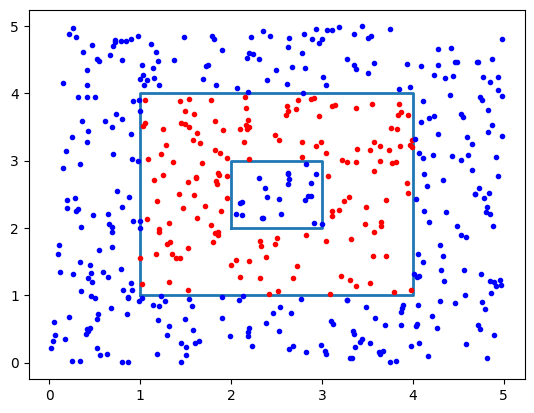

In [5]:
from shapely.geometry import Point, Polygon

def inpolygon(point_x, point_y, polygon_x, polygon_y):
    """
    Check if points are inside or on the edge of a polygonal region.

    Args:
        point_x (float or list): X-coordinates of the points to check.
        point_y (float or list): Y-coordinates of the points to check.
        polygon_x (list): X-coordinates of the polygon vertices.
        polygon_y (list): Y-coordinates of the polygon vertices.

    Returns:
        list: A list of boolean values indicating whether each point is inside or on the edge of the polygon.
    """
    # Create a Polygon object from the polygon vertices
    polygon = Polygon(list(zip(polygon_x, polygon_y)))

    # If single point coordinates are provided, convert them into a list
    if isinstance(point_x, (int, float)):
        point_x = [point_x]
        point_y = [point_y]

    # Create Point objects for the input points
    points = [Point(x, y) for x, y in zip(point_x, point_y)]

    # Check if each point is inside or on the edge of the polygon
    # is_inside = [point.within(polygon) for point in points]

    # is_inside = [polygon.contains(point) for point in points]
    is_inside = [polygon.covers(point) for point in points]

    return np.array(is_inside)


xv = np.array([1, 4, 4, 1, 1, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, 2, 3, 3, 2, 2])

np.random.seed()  # Use a random seed for default behavior
xq = np.random.rand(500, 1) * 5
yq = np.random.rand(500, 1) * 5

in_ = inpolygon(xq,yq,xv,yv)

xv = np.array([1, 4, 4, 1, 1, np.nan, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, np.nan, 2, 3, 3, 2, 2])
plt.plot(xv, yv, linewidth=2)
plt.plot(xq[in_], yq[in_], 'r.')
plt.plot(xq[np.logical_not(in_)], yq[ np.logical_not(in_)], 'b.')

In [6]:
def get_two_room(cfg_path: str = '../cfg/envs/two_room.ini') -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(cfg_path)
    geometry = get_geometry_params(config)

    # Scale the objects to full width after coords were between -10 and 10
    scale = config.eval('BuildingBoundaries', 'scale')
    # geometry.objects.x = [[scale * x for x in row] for row in geometry.objects.x]
    # geometry.objects.y = [[scale * y for y in row] for row in geometry.objects.y]
    geometry.objects.x *= scale
    geometry.objects.y *= scale

    return geometry


def get_preplay_env(preplay_env_closed_cfg_path: str) -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(preplay_env_closed_cfg_path)
    datapath = config.eval('ExternalSources', 'paths')
    red_grid = np.load(datapath)[2:-2, 2:-2]
    y_range = config.eval('RoomDimensions', 'y_range', locals={'red_grid': red_grid})
    x_barrier_top_min = (red_grid[y_range // 2, :] == 1).argmax() + 1
    y_barrier_top = np.where(red_grid[:, -1] == 1)[0][-1] + 1
    x_barrier_bot_min = x_barrier_top_min
    y_barrier_bot = np.where(red_grid[:, -1] == 1)[0][0] + 1

    return get_geometry_params(
        config,
        locals={
            'red_grid': red_grid,
            'x_barrier_bot_min': x_barrier_bot_min,
            'x_barrier_top_min': x_barrier_top_min,
            'y_barrier_bot': y_barrier_bot,
            'y_barrier_top': y_barrier_top,
        }
    )


def get_complex_grid(geometry: GeometryParams, res: float) -> np.ndarray: #!
    min_xy, max_xy = geometry.min_xy, geometry.max_xy
    grid_x = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the x-axis
    grid_y = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the y-axis

    # Create 2D grids of x and y values
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    # Convert Cartesian coordinates to complex numbers
    complex_grid = grid_x + 1j * grid_y

    # Reshape the complex grid into a 1D vector of grid points (x and y values as complex numbers)
    complex_grid = complex_grid.reshape(-1, 1)

    return complex_grid, grid_x, grid_y


def get_geometry_name(config: str | configparser.ConfigParser) -> str:

    if isinstance(config, str):
        cfg = configparser.ConfigParser(allow_no_value=True)
        cfg.read(config)
        config = cfg

    environment_section = config['Environment']
    two_room = environment_section.getboolean('two_room')
    square_room = environment_section.getboolean('square_room')
    inserted_barrier = environment_section.getboolean('inserted_barrier')
    preplay_env_closed = environment_section.getboolean('preplay_env_closed')
    preplay_env_open = environment_section.getboolean('preplay_env_open')

    if two_room:
        return 'two_room'
    elif square_room:
        return 'squared_room'
    elif inserted_barrier:
        return 'inserted_barrier'
    elif preplay_env_open:
        return 'preplay_env_open'
    elif preplay_env_closed:
        return 'preplay_env_closed'


def get_geometry_by_name(cfg_path: str, geometry_name: str) -> tuple[GeometryParams, int]:

    match geometry_name:
        case 'two_room':
            geometry = get_two_room(cfg_path)
            n_textures = geometry.n_polygons + 2
        case 'squared_room':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons
        case 'inserted_barrier':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons + 1
        case 'preplay_env_closed' | 'preplay_env_open':
            geometry = get_preplay_env(cfg_path)
            n_textures = geometry.n_polygons
        case _:
            raise ValueError(f"Unsupported geometry name: {geometry_name}")

    return geometry, n_textures

class AbstractBuildingGeometryProcessor(ABC):

    @abstractmethod
    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        pass

    def __call__(self, geometry: GeometryParams, complex_grid: np.ndarray):
        foreground_pts = []  # Will be the possible locations from above that are inside buildings
        line_tex = []  # Identity of each line
        dir_ = []  # Direction of each line
        r0 = []  # Starting point of each line
        for poly in range(1, geometry.n_polygons + 1):
            # Create complex vertices for the current polygon
            vertices = np.array(geometry.objects.x[poly - 1, :] + 1j * geometry.objects.y[poly - 1, :])
            vertices = vertices[:geometry.n_vertices[poly - 1]]

            # Find locations inside this building
            in_poly_pts = np.where(inpolygon(complex_grid.real, complex_grid.imag, vertices.real, -vertices.imag))

            # Locations inside this building, foreground in the sense of looking at the map from above
            # The ground is background, buildings are foreground
            foreground_pts.extend(in_poly_pts[0])

            # Loop over "lines" of the building (same as # of vertices)
            for polyline in range(geometry.n_vertices[poly - 1] - 1):
                xi, xf = geometry.objects.x.T[polyline:polyline + 2, poly - 1]
                yi, yf = geometry.objects.y.T[polyline:polyline + 2, poly - 1]
                line_tex.append(self.get_line_identity(poly, xf, xi))

                dir_.append([xf - xi, yf - yi, 0])  # Line vectors, from one vertex of a building to the next
                r0.append([xi, yi, 0])  # Line start

        return np.array(foreground_pts), np.array(line_tex), np.array(dir_), np.array(r0)


class StandartBuildingGeometryProcessor(AbstractBuildingGeometryProcessor):
    def __init__(self, geometry_name: str):
        if geometry_name not in (
            'two_room',
            'squared_room',
            'inserted_barrier',
            'preplay_env_open',
            'preplay_env_closed'
        ):
            raise NotImplementedError(f'Invalid geometry name: {geometry_name}')

        self.geometry_name = geometry_name

    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        match self.geometry_name:
            case 'two_room':
                if poly >= 3 or (poly == 2 and xf > 0 and xi > 0):
                    return poly + 1
                else:
                    return poly
            case 'squared_room' | 'preplay_env_open' | 'preplay_env_closed':
                return poly
            case 'inserted_barrier':
                if poly >= 5 or (poly == 5 and (xf == 14 and xi == 8 or xf == 8 and xi == 14)):
                    return poly + 1
                else:
                    return poly


@dataclass
class AbstractSpace(ABC):
    coords: Coordinates2D


@dataclass
class TrainingSpace(AbstractSpace): #!
    coords: Coordinates2D
    identities: np.ndarray
    directions: np.ndarray
    starting_points: np.ndarray
    resolution: float

    def __post_init__(self):
        if self.directions.shape != self.starting_points.shape:
            raise ValueError(
                'directions and starting_points must have the same shape, '
                f'got {self.directions.shape} and {self.starting_points.shape} instead'
            )
        if len(self.identities) != len(self.directions):
            raise ValueError(
                'identities and directions must have the same length, '
                f'got {len(self.identities)} and {len(self.directions)} instead'
            )
    def plot(self, ax: plt.Axes = None, *args, **kwargs) -> plt.Figure | None:
        if not len(args) and not len(kwargs):
            args = 's',
            kwargs = dict(color='tab:gray')
        if ax is not None:
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
        else:
            fig, ax = plt.subplots()
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
            return fig


def process_training_space(
    geometry: GeometryParams,
    res: float,
    building_geometry_processor: AbstractBuildingGeometryProcessor,
    *args, **kwargs
) -> TrainingSpace:
    # Get the complex grid
    complex_grid, grid_x, grid_y = get_complex_grid(geometry, res)

    # Process building geometry
    building_geometry_processor = building_geometry_processor(*args, **kwargs)
    foreground_pts, line_tex, dir_, r0 = building_geometry_processor(geometry, complex_grid)

    # Create background_x and background_y based on grid_x and grid_y
    background_x = grid_x.copy()
    shape = background_x.shape
    background_x = background_x.T.reshape(-1)
    background_y = grid_y.copy()
    background_y = background_y.T.reshape(-1)

    # Convert the elements which lie within the buildings into non-numbers (NaN)
    background_x[foreground_pts] = np.nan
    background_y[foreground_pts] = np.nan

    # Reshape background_x and background_y
    background_x = background_x.reshape(shape[::-1]).T
    background_y = background_y.reshape(shape[::-1]).T

    # Remove the non-numbers (NaN) from the arrays - forms a column vector
    background_x = background_x.T[np.isfinite(background_x).T]
    background_y = background_y.T[np.isfinite(background_y).T]

    # Find the indices of locations outside of objects, but inside training rect.
    train_ind = np.where(
        (background_x > geometry.min_train.x) &
        (background_x < geometry.max_train.x) &
        (background_y > geometry.min_train.y) &
        (background_y < geometry.max_train.y)
    )[0]


    # Extract the coordinates within the specified range
    train_x = background_x[train_ind]
    train_y = background_y[train_ind]

    return TrainingSpace(Coordinates2D(train_x, train_y), line_tex, dir_, r0, res)


@dataclass
class Boundary:
    coords: Coordinates2D
    textures: np.ndarray

    def __post_init__(self):
        if self.coords.x.shape != self.coords.y.shape:
            raise ValueError(f'x and y must have the same shape, got {self.coords.x.shape} and {self.coords.y.shape} instead')
        if len(self.coords.x) != len(self.textures):
            raise ValueError(f'points and textures must have the same length, got {len(self.coords.x)} and {len(self.textures)} instead')


def process_boundary(training_space: TrainingSpace) -> Boundary:
    total_lines = len(training_space.identities)

    boundary_len = np.linalg.norm(training_space.directions, axis=1)
    Dir_unit = training_space.directions / boundary_len[:, np.newaxis]
    boundary_len[np.where(np.isclose(boundary_len % training_space.resolution, 0))[0]] += training_space.resolution

    boundary_points_x = []
    boundary_points_y = []
    boundary_textures = []

    for boundary in range(total_lines):
        x = training_space.starting_points[boundary, 0] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 0]
        y = training_space.starting_points[boundary, 1] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 1]

        boundary_points_x.extend(x.tolist())
        boundary_points_y.extend(y.tolist())
        boundary_textures.extend(np.full(len(x), training_space.identities[boundary]))

    boundary_points_x = np.array(boundary_points_x)
    boundary_points_y = np.array(boundary_points_y)
    boundary_textures = np.array(boundary_textures)

    return Boundary(Coordinates2D(boundary_points_x, boundary_points_y), boundary_textures)


def compute_intersection(point1: np.ndarray, point2: np.ndarray, direction1: np.ndarray, direction2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Calculate how far along each line two lines intersect.

    denominator_2 = np.cross(direction1, direction2).astype(float)  # Cross product of direction1 and direction2
    denominator_2[denominator_2 == 0] = np.nan

    denominator_1 = -denominator_2

    alpha2 = np.cross(point2 - point1, direction1) / denominator_2
    alpha1 = np.cross(point1 - point2, direction2) / denominator_1

    return alpha1[:, 2], alpha2[:, 2]


@dataclass
class VisiblePlane(Boundary):
    training_locations: np.ndarray
    def __post_init__(self):
        super().__post_init__()
        if len(self.coords.x) != len(self.training_locations):
            raise ValueError(f'points and training_locations must have the same length, got {len(self.coords.x)} and {len(self.training_locations)} instead')

def process_visible_plane(boundary: Boundary, training_space: TrainingSpace) -> VisiblePlane:

    n_boundary_points = boundary.coords.x.shape[0]
    n_training_points = training_space.coords.x.shape[0]

    visible_plane = np.full((2, n_boundary_points, n_training_points), np.nan)
    texture = np.full((n_training_points, n_boundary_points), np.nan)

    training_locations = np.zeros((n_training_points, 2))
    occluded_points = np.zeros(n_boundary_points, dtype=bool)

    for location in range(n_training_points):
        pos = Coordinates2D(training_space.coords.x[location], training_space.coords.y[location])
        training_locations[location] = [pos.x, pos.y]

        local_r0 = training_space.starting_points - np.array([pos.x, pos.y, 0])
        Loc_bndry_pts = np.column_stack((boundary.coords.x - pos.x, boundary.coords.y - pos.y, np.zeros(n_boundary_points)))

        occluded_points.fill(False)

        for occ_bndry in range(len(training_space.identities)):
            alpha_pt, alpha_occ = compute_intersection(
                np.zeros((n_boundary_points, 3)),
                np.expand_dims(local_r0[occ_bndry], 0),
                Loc_bndry_pts,
                np.expand_dims(training_space.directions[occ_bndry], 0)
            )

            occluded_points |= (alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ <= 1) & (alpha_occ >= 0)

        unocc_ind = np.where(~occluded_points)[0]
        num_vis_pts = unocc_ind.size

        visible_plane[:, :num_vis_pts, location] = Loc_bndry_pts[unocc_ind, :2].T + np.array([pos.x, pos.y])[:, np.newaxis]
        texture[location, :num_vis_pts] = boundary.textures[unocc_ind].T

    visible_plane = Coordinates2D(visible_plane[0].T, visible_plane[1].T)

    return VisiblePlane(visible_plane, texture, training_locations)


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from typing import Callable, Any, Optional
from utils.data import save_pkl, read_pkl

def shuffle_visible_plane(visible_plane: VisiblePlane) -> VisiblePlane:

    permutation = np.random.permutation(len(visible_plane.textures))
    return VisiblePlane(
        Coordinates2D(visible_plane.coords.x[permutation],
        visible_plane.coords.y[permutation]),
        visible_plane.textures[permutation],
        visible_plane.training_locations[permutation]
    )

@dataclass
class Geometry:
    params: GeometryParams
    n_textures: int
    training_space: TrainingSpace
    boundary: Boundary
    visible_plane: VisiblePlane

    def save(self, path: str):
        save_pkl(self, path)

    @staticmethod
    def load(path: str):
        return read_pkl(path)

    def shuffle_visible_plane(self) -> VisiblePlane:
        return shuffle_visible_plane(self.visible_plane)

class GeometryFactory:
    def __init__(
        self,
        cfg_path: str,
        geometry_getter: Callable[[tuple[Any, ...]], tuple[GeometryParams, int]],
        building_geometry_processor: Callable[
            [
                GeometryParams,
                float,
                AbstractBuildingGeometryProcessor,
                Optional[tuple[Any, ...]],
                Optional[dict[str, Any]]
            ], TrainingSpace
        ],
        res: float = .3,
    ):
        self.cfg_path = cfg_path
        self.geometry_getter = geometry_getter
        self.building_geometry_processor = building_geometry_processor
        self.res = res

    def __call__(self, getter_kwargs: dict[str, Any]= None, building_processor_kwargs: dict[str, Any] = None):
        if getter_kwargs is None:
            getter_kwargs = {}
        geometry, n_textures = self.geometry_getter(self.cfg_path, **getter_kwargs)
        training_space = process_training_space(geometry, self.res, self.building_geometry_processor, **building_processor_kwargs)
        boundary = process_boundary(training_space)
        visible_plane = process_visible_plane(boundary, training_space)
        return Geometry(geometry, n_textures, training_space, boundary, visible_plane)


## Initialize room pre play file

In [200]:
np.save('../data/room/roomGridPrePlay', np.heaviside(np.random.normal(0, 1, (40, 40)), 0))

In [6]:
from scipy.io import loadmat
mat = loadmat('../data/room/roomGridPrePlay.mat')
np.save('../data/room/roomGridPrePlay', mat['roomGridPrePlay'])

## Main script

In [9]:
# Create a configparser object
config = configparser.ConfigParser()

# Read the INI file
config.read('../cfg/envs/wts.ini')  # Replace 'your_ini_file.ini' with the actual file path

# Access the variables
flags_section = config['Flags']
GEOMflag = flags_section.getboolean('GEOMflag')
MTLflag = flags_section.getboolean('MTLflag')
HDflag = flags_section.getboolean('HDflag')
TRflag = flags_section.getboolean('TRflag')

environment_section = config['Environment']
two_room = environment_section.getboolean('two_room')
square_room = environment_section.getboolean('square_room')
inserted_barrier = environment_section.getboolean('inserted_barrier')
preplay_env_closed = environment_section.getboolean('preplay_env_closed')
preplay_env_open = environment_section.getboolean('preplay_env_open')
geometry_name = get_geometry_name(config)


params_section = config['Parameters']
namestrg = params_section['namestrg']
res = params_section.getfloat('res')


cfg_dir = '../cfg/envs/'
two_room_cfg = os.path.join(cfg_dir, 'two_room.ini')
square_room_cfg = os.path.join(cfg_dir, 'square_room.ini')
inserted_barrier_cfg = os.path.join(cfg_dir, 'inserted_barrier.ini')
preplay_env_closed_cfg = os.path.join(cfg_dir, 'preplay_env_closed.ini')
preplay_env_open_cfg = os.path.join(cfg_dir, 'preplay_env_open.ini')

In [13]:
wts_cfg_path = '../cfg/envs/wts.ini'

GEOMflag = True
# geometry_name = 'two_room'
# cfg_path = two_room_cfg
geometry_name = 'squared_room'
cfg_path = square_room_cfg
# geometry_name = 'inserted_barrier'
# cfg_path = inserted_barrier_cfg
# geometry_name = 'preplay_env_closed'
# cfg_path = preplay_env_closed_cfg
# geometry_name = 'preplay_env_open'
# cfg_path = preplay_env_open_cfg

if GEOMflag:
    kwargs = dict(geometry_name=get_geometry_name(wts_cfg_path))
    geometry = GeometryFactory(
        square_room_cfg,
        get_geometry_by_name,
        StandartBuildingGeometryProcessor,
        res
    )(
        kwargs,
        kwargs
    )


In [233]:
geometry

KeyboardInterrupt: 

In [180]:
GEOMflag = True
# geometry_name = 'two_room'
# cfg_path = two_room_cfg
geometry_name = 'squared_room'
cfg_path = square_room_cfg
# geometry_name = 'inserted_barrier'
# cfg_path = inserted_barrier_cfg
# geometry_name = 'preplay_env_closed'
# cfg_path = preplay_env_closed_cfg
# geometry_name = 'preplay_env_open'
# cfg_path = preplay_env_open_cfg

if GEOMflag:
    geometry, n_textures = get_geometry_by_name(geometry_name, cfg_path)
    training_space = process_training_space(geometry, res, StandartBuildingGeometryProcessor, geometry_name)
    boundary = process_boundary(training_space)
    visible_plane = process_visible_plane(boundary, training_space)
